# Avaliação 04 - Introdução ao Aprendizado de Máquina (ENGG67)
**Alunos:**

- **Daniel da Rocha Carneiro**

- **Maurício dos Santos de Jesus**

- **Theo Farias**

----------

### 1) Escolha uma tarefa de classificação ou regressão que possa ser abordada utilizando MLPs. Selecione um banco de dados adequado (sugestões em https://archive.ics.uci.edu/). Projete e treine uma rede MLP de duas camadas para resolver a tarefa pretendida. Utilize o método de validação cruzada k-fold para avaliar o treinamento do modelo.

#### Problema escolhido

Para esse trabalho, a equipe escolheu o dataset "Wine Quality", que possui duas bases de dados relacionadas a samples de vinho tinto e vinho branco do norte de Portugal. O objetivo do modelo padrão é de classificar a qualidade do vinho (de 0 a 10), utilizando os 11 atributos derivados de teste físico-químicos. Porém, o grupo optou por utilizar uma derivação deste problema, que está em identificar se o vinho é tinto ou branco, com base nos 11 atributos fornecidos. O grupo optou por não utilizar o atributo "quality", utilizado como output no problema original.

O problema foi abordado realizando inicialmente a importação das bibliotecas e datasets, análises de completudide e dos atributos presentes através de funções de densidade para posterior solução através de uma MLP com 2 camadas ocultas. Após realizar a validação para um dataset dividido aleatóriamente como 70% treinamento e 30% teste, o grupo então realizou a validação do treinamento da rede utilizando validação cruzada K-fold.

## Importação dos dados e bibliotecas



In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model
from numpy import *

In [2]:
# Abre os datasets
red = pd.read_csv('dataset/winequality-red.csv', delimiter=";")
white = pd.read_csv('dataset/winequality-white.csv', delimiter=";")

# Classifica os tipos e une os datasets
red['type'] = 1
white['type'] = 0

# frames = [red, white]
# wines = pd.concat(frames, ignore_index=True)
# wines.columns = wines.columns.str.strip()

### Balanceamento dos dados

Como a base de dados apresenta quase 3 vezes mais dados referentes a classe de vinho tinto. Balanceou-se os dados utilizando o método de undersample aleatório para que número de amostras de vinho tinto fosse o mesmo de vinho branco

Text(0, 0.5, 'Contagem')

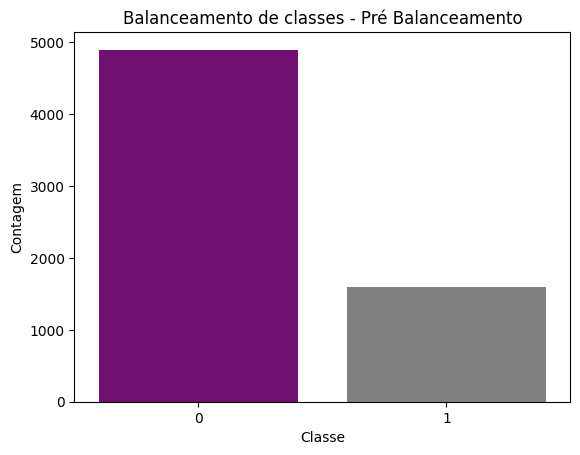

In [111]:
red_count = len(red)
white_count = len(white)
undersampled_white = white.groupby('type').apply(lambda x: x.sample(n=red_count, random_state=42)).reset_index(drop=True)
frames = [red, white]
winesUnbalanced = pd.concat(frames, ignore_index=True)

colors = ["purple", "gray"]
sns.countplot(x=winesUnbalanced["type"],palette=colors)
plt.title('Balanceamento de classes - Pré Balanceamento')
plt.xlabel('Classe')
plt.ylabel('Contagem')

Text(0, 0.5, 'Contagem')

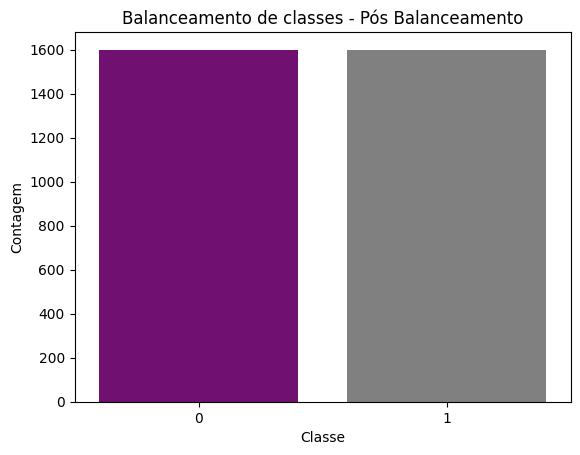

In [112]:
frames = [red, undersampled_white]

wines = pd.concat(frames, ignore_index=True)
wines.columns = wines.columns.str.strip()


colors = ["purple", "gray"]
sns.countplot(x=wines["type"],palette=colors)
plt.title('Balanceamento de classes - Pós Balanceamento')
plt.xlabel('Classe')
plt.ylabel('Contagem')

## Verifica informações e integridade dos dados

In [113]:
print(wines.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3198 entries, 0 to 3197
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         3198 non-null   float64
 1   volatile acidity      3198 non-null   float64
 2   citric acid           3198 non-null   float64
 3   residual sugar        3198 non-null   float64
 4   chlorides             3198 non-null   float64
 5   free sulfur dioxide   3198 non-null   float64
 6   total sulfur dioxide  3198 non-null   float64
 7   density               3198 non-null   float64
 8   pH                    3198 non-null   float64
 9   sulphates             3198 non-null   float64
 10  alcohol               3198 non-null   float64
 11  quality               3198 non-null   int64  
 12  type                  3198 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 324.9 KB
None


In [114]:
# Checa a integridade da base de dados
def has_true_value(matrix):
    for row in matrix:
        for element in row:
            if element is True:
                return True
    return False

if has_true_value(pd.isnull(white)):
    
    print("A base de dados possui valores vazios.")
else:
    print("A base de dados não possui valores vazios")

pd.isnull(white)

A base de dados não possui valores vazios


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4893,False,False,False,False,False,False,False,False,False,False,False,False,False
4894,False,False,False,False,False,False,False,False,False,False,False,False,False
4895,False,False,False,False,False,False,False,False,False,False,False,False,False
4896,False,False,False,False,False,False,False,False,False,False,False,False,False


## Gráficos de densidade para os atributos

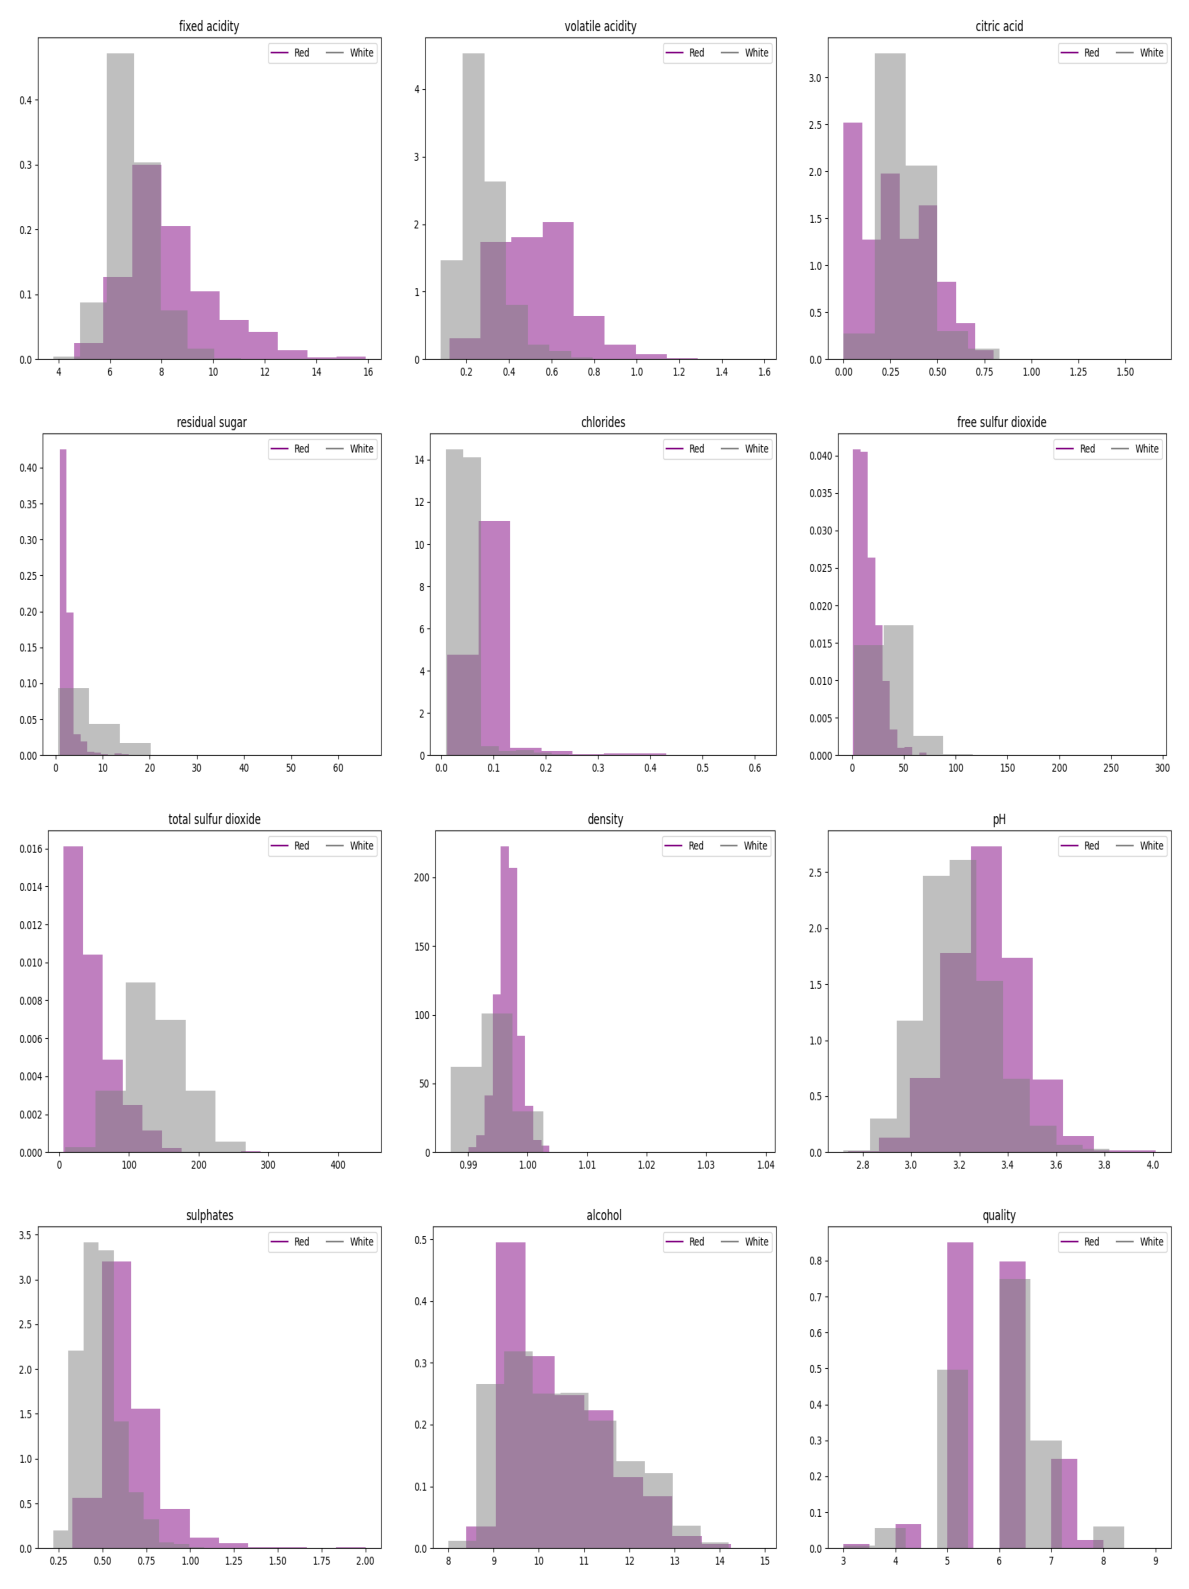

In [102]:
# Density grid
dens_grid = []
column_names = wines.columns.tolist()
for var in column_names:
    # Build the plots
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    for type_val, color_label, zone_color in zip(wines['type'].unique(), ['Red', 'White'], ['purple', 'gray']):
        data = wines[wines['type'] == type_val][var]
        ax.hist(data, density=True, alpha=0.5, label=color_label, color=zone_color)
    ax.set_title(var)
    ax.legend()
    legend_labels = ['Red', 'White']
    legend_colors = ['purple', 'gray']
    legend_handles = [plt.Line2D([], [], color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
    ax.legend(handles=legend_handles, labels=legend_labels, ncol=len(legend_labels))
    dens_grid.append(fig)
    plt.close(fig)  # Close the figure without displaying it

nrow = 4
ncol = 3
fig, axes = plt.subplots(nrow, ncol, figsize=(12, 16))
# Iterate over dens_grid and populate the subplots
for i, ax in enumerate(axes.flatten()):
    if i < len(dens_grid):
        fig = dens_grid[i]
        fig.tight_layout()  # Adjust layout within each figure
        fig.canvas.draw()  # Update the figure canvas
        ax.imshow(np.array(fig.canvas.renderer.buffer_rgba()), aspect='auto')
    ax.axis('off')




plt.tight_layout()
plt.show()

## Separa os dados de treinamento e teste

Para realizar testes rápidos e a fim de comparar os resultados com a próxima etapa implementada (utilizando validação cruzada), é possível utilizar as seções a seguir para configurar a rede neural a ser utilizada no K-Fold

In [103]:
# Specify the data 
x=wines.iloc[:,0:10] #Corta os atributos "quality e "type" para os dados utilizados para classificação

# Target label
y= np.ravel(wines.type)

# Creating training and test datasets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

# Define the scaler for normalization
scaler = StandardScaler().fit(X_train)

# Normalize the training dataset
X_train = scaler.transform(X_train)

# Normalize the test dataset
X_test = scaler.transform(X_test)


## Instancia e treina a rede neural para o conjunto separado

Foi instanciada uma rede neural com 1 camada de entrada, 2 camadas ocultas e 1 camada de saída.

- A camada de entrada utiliza a função de ativação ReLU e possui 11 neurônios (equivalente ao número de entradas).

- A primeira camada oculta também utilizada a função de ativação ReLU e possui 6 neurônios. (O número de neurônios foi definidido empiracamente)

- A segunda camada oculta utilizada a função de ativação tangente hiperbólica e possui 3 neurônios. (O número de neurônios foi definidido empiracamente)

- A camada de saída utilizada a função de ativação sigmoide e possui apenas 1 neurônio.

Para treinamento, foram adotados 5 épocas e um número de batch equivalente ao tamanho dos dataset separado para treinamento

A acurácia da rede foi determinada utilizando o conjunto de dados para testes

In [107]:
# Initialize the model

NEPOCHS = 3
model = 0
model = Sequential()

# Configuring layers
# Input layer using the rectified linear unit activation function
model.add(Dense(10, activation='relu', input_shape=(10,), name="CamadaDeEntrada"))

# First hidden layer  using the rectified linear unit activation function
model.add(Dense(10, activation='tanh', name="HiddenLayer"))

# Second hidden layer  using the hiperpolic tangent activation function
model.add(Dense(5, activation='sigmoid', name="HiddenLayer2"))

# Output layer using the sigmoid (s-function) activation function
model.add(Dense(1, activation='sigmoid', name="CamadaDeSaida"))

# Compile and fit the model
model.compile(loss='MeanSquaredError',
              optimizer='adam',
              metrics=['accuracy'])
                   
model.fit(X_train, y_train,epochs=NEPOCHS, batch_size=1, verbose=1)




score = model.evaluate(X_test, y_test,verbose=0)
y_pred = model.predict(X_test)
y_pred = y_pred > 0.5

y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = y_test

# [loss, accuracy]
print('------------------------------------------------------------------------')
print(f'{model.metrics_names[0]} of {score[0]*100}%\n{model.metrics_names[1]} of {score[1]*100}%')

Epoch 1/3
4547/4547 [==============================] - 4s 731us/step - loss: 0.0416 - accuracy: 0.9661
Epoch 2/3
4547/4547 [==============================] - 3s 713us/step - loss: 0.0060 - accuracy: 0.9941
Epoch 3/3
61/61 [==============================] - 0s 579us/step
------------------------------------------------------------------------
loss of 0.5732202902436256%
accuracy of 99.43589568138123%


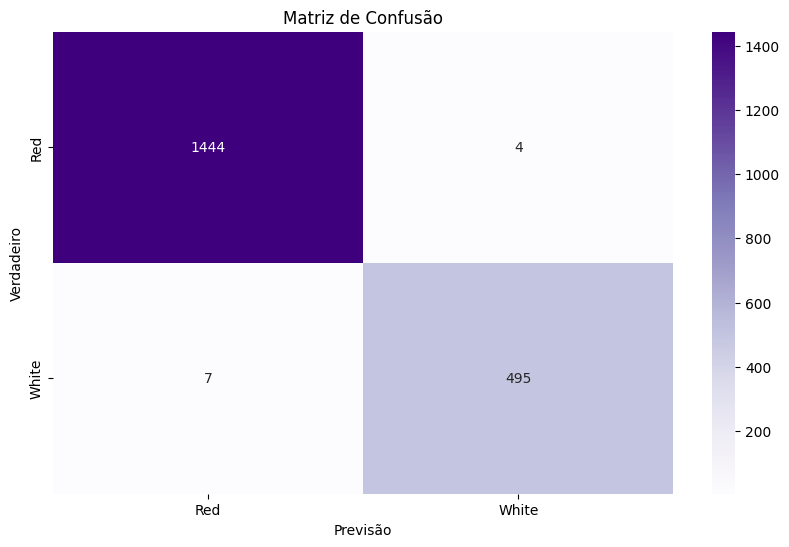

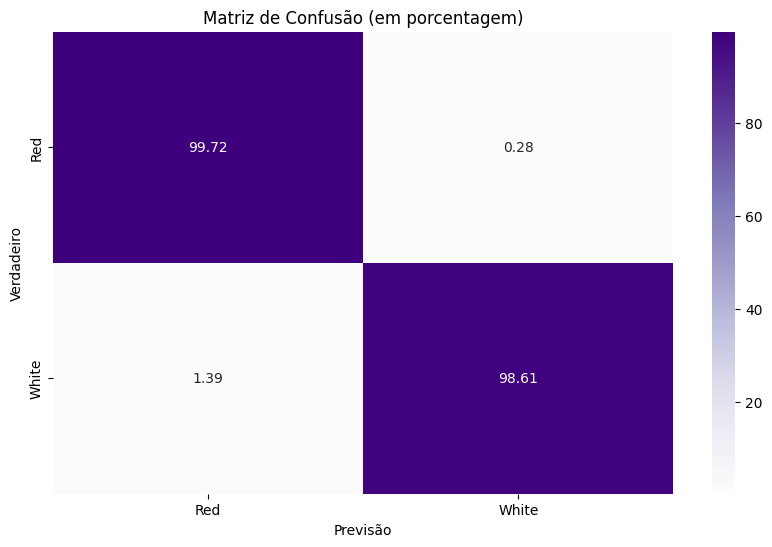

In [108]:
classes = ['Red', 'White']
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, xticklabels=classes, yticklabels=classes, cmap="Purples", fmt="g")
plt.xlabel('Previsão'); plt.ylabel('Verdadeiro'); plt.title('Matriz de Confusão')

plt.show()

cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 6))
sns.heatmap(cm_percentage, annot=True, xticklabels=classes, yticklabels=classes, cmap="Purples", fmt=".2f")
plt.xlabel('Previsão'); plt.ylabel('Verdadeiro'); plt.title('Matriz de Confusão (em porcentagem)')
plt.show()

## Verifica o formato da rede utilizada

Model: "sequential_170"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CamadaDeEntrada (Dense)     (None, 10)                110       
                                                                 
 HiddenLayer (Dense)         (None, 10)                110       
                                                                 
 HiddenLayer2 (Dense)        (None, 5)                 55        
                                                                 
 CamadaDeSaida (Dense)       (None, 1)                 6         
                                                                 
Total params: 281 (1.10 KB)
Trainable params: 281 (1.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


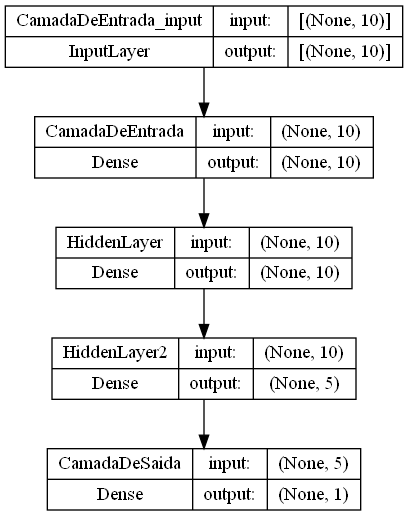

In [109]:
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Realizando a validação cruzada

Utiliza o método K-fold para realizar a validação cruzada da rede proposta na seção anterior, utilizando 10 folds com 5 épocas cada

In [96]:
# Define the K-fold Cross Validator
NSPLITS = 10
NEPOCHS = 5


kfold = KFold(n_splits=NSPLITS, shuffle=False)


# K-fold Cross Validation model evaluation
acc_per_fold = []
loss_per_fold= []
y_predics = []
y_tests = []

fold_no = 1
for train_index, test_index  in kfold.split(x,y):
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')


    model = None
    model = Sequential()

    # Configuring layers
    # Input layer using the rectified linear unit activation function
    model.add(Dense(10, activation='relu', input_shape=(10,), name="CamadaDeEntrada"))

    # First hidden layer  using the rectified linear unit activation function
    model.add(Dense(10, activation='tanh', name="HiddenLayer"))

    # Second hidden layer  using the hiperpolic tangent activation function
    model.add(Dense(5, activation='sigmoid', name="HiddenLayer2"))

    # Output layer using the sigmoid (s-function) activation function
    model.add(Dense(1, activation='sigmoid', name="CamadaDeSaida"))

    # Compile and fit the model
    model.compile(loss='mean_squared_error',
                optimizer='adam',
                metrics=['accuracy'])
    
    
    history = model.fit(x.iloc[train_index], y[train_index],epochs=NEPOCHS, batch_size=1, verbose=1)

    score = model.evaluate(x.iloc[test_index], y[test_index],verbose=0)



    # Generate generalization metrics
    print('------------------------------------------------------------------------')
    print(f'Score for fold {fold_no}:\n {model.metrics_names[1]} of {score[1]*100}%')
    print('------------------------------------------------------------------------\n')
    acc_per_fold.append(score[1] * 100)
    loss_per_fold.append(score[0])

    score = model.evaluate(x.iloc[test_index], y[test_index], verbose=0)

    y_pred = model.predict(x.iloc[test_index])
    y_pred = np.round(y_pred).astype(int)
    y_test = y[test_index]

    y_predics.extend(y_pred)
    y_tests.extend(y_test)

    # Increase fold number
    fold_no = fold_no + 1

average_score = np.mean(acc_per_fold)
stdScore = np.std(acc_per_fold)
print("Acurácia média:", average_score)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/5
2878/2878 [==============================] - 2s 689us/step - loss: 0.1372 - accuracy: 0.8697
Epoch 2/5
2878/2878 [==============================] - 2s 705us/step - loss: 0.0653 - accuracy: 0.9232
Epoch 3/5
2878/2878 [==============================] - 2s 686us/step - loss: 0.0589 - accuracy: 0.9270
Epoch 4/5
2878/2878 [==============================] - 2s 685us/step - loss: 0.0576 - accuracy: 0.9232
Epoch 5/5
2878/2878 [==============================] - 2s 690us/step - loss: 0.0519 - accuracy: 0.9305
------------------------------------------------------------------------
Score for fold 1:
 accuracy of 78.4375011920929%
------------------------------------------------------------------------

10/10 [==============================] - 0s 606us/step
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/5
2878/2878 [===================

## Resultados obtidos

**_OBS:_** A seção anterior precisa ser executada por completo para que a seção abaixo seja executada sem erros

Acurácia média é de 90.40±5.36%.


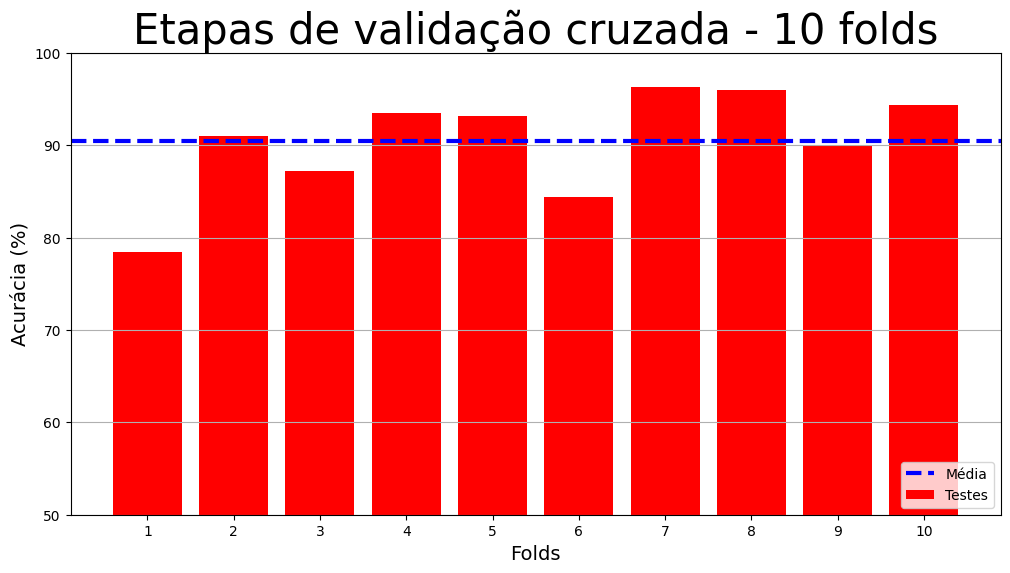

In [97]:

print('Acurácia média é de ' + "{:.2f}".format(average_score) + '±' + "{:.2f}".format(stdScore) + '%.')
plt.figure(figsize=(12,6))
labels = [str(i) for i in range(1, len(acc_per_fold) + 1)]
X_axis = np.arange(len(labels))
ax = plt.gca()
plt.ylim(50, 100)
plt.bar(X_axis, acc_per_fold, 0.8, color='red', label='Testes')
plt.axhline(average_score, 0 , 9, color='b', linestyle='--', linewidth=3, label='Média')
plt.title("Etapas de validação cruzada - " + str(NSPLITS) + " folds", fontsize=30)
plt.xticks(X_axis, labels)
plt.xlabel("Folds", fontsize=14)
plt.ylabel("Acurácia (%)", fontsize=14)
plt.legend(loc=4)
plt.gca().yaxis.grid(True)
plt.show()

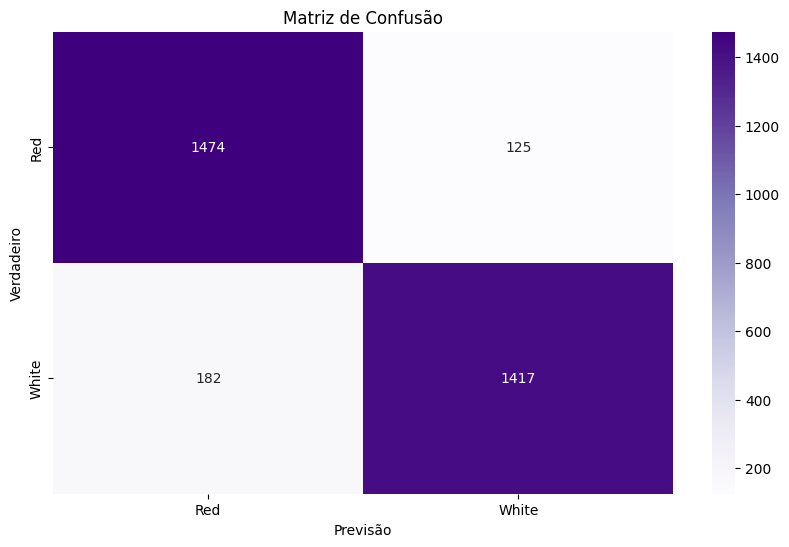

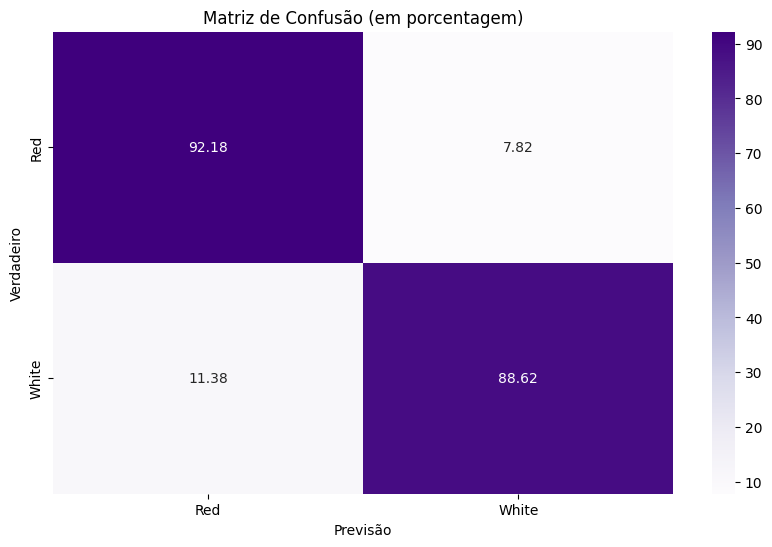

In [98]:
classes = ['Red', 'White']
cmKfold = confusion_matrix(y_tests, y_predics)

plt.figure(figsize=(10,6))
sns.heatmap(cmKfold, annot=True, xticklabels=classes, yticklabels=classes, cmap="Purples", fmt="g")
plt.xlabel('Previsão'); plt.ylabel('Verdadeiro'); plt.title('Matriz de Confusão')

plt.show()

cmKfold_percentage = cmKfold.astype('float') / cmKfold.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 6))
sns.heatmap(cmKfold_percentage, annot=True, xticklabels=classes, yticklabels=classes, cmap="Purples", fmt=".2f")
plt.xlabel('Previsão'); plt.ylabel('Verdadeiro'); plt.title('Matriz de Confusão (em porcentagem)')
plt.show()